In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
from plot_config import *

In [3]:
from utils import *

In [23]:
# rerun = True
regen_talk = True

In [5]:
limit = 1825

In [6]:
just_for_time = '/sciserver/filedb10-01/ocean/wenrui_temp/vol_budget'

rtime = np.array(xr.open_zarr(just_for_time).time)

In [7]:
if rerun:
    for which in ['domain_all','domain4']:
        if which == 'domain_all':
            ds = open_domain_all()
        elif which == 'domain4':
            ds = open_domain4()
        
        # %%time
        terms = {}
        for var in rhs_list:
            terms[var] = [0]
        for i in range(1,len(rtime),1):
            print(i,end = ' ')
            length = np.minimum(i+1,limit)
            stupid_xr_vec = xr.DataArray(np.arange(length), dims = 'stupid')
            for var in rhs_list:
                slc = ds[var][i-stupid_xr_vec,stupid_xr_vec]
                terms[var].append(np.nansum(slc))
        
        to_output = xr.Dataset()
        for var in terms.keys():
            to_output[var] = xr.DataArray(terms[var],dims = 'dummy')
        to_output.to_zarr(f'lineplotprep/contr_{which}')
        
        indices = np.arange(1,len(rtime),1)
        slast = np.array(ds.sl[:,0])[indices]
        sfirst = np.zeros_like(slast)
        part1992 = indices[indices<limit]
        part5yr = indices[indices>=limit]
        sfirst[:len(part1992)] = np.array(ds.sf[0,:])[part1992]
        sfirst[-len(part5yr):] = np.array(ds.sf[:,limit-1])[part5yr - limit]
        
        for var in rhs_list:
            terms[var] = np.array(terms[var])
        
        sums = np.zeros_like(terms['A'])
        for var in rhs_list:
            sums+= np.array(terms[var])
        
        np.save(f'lineplotprep/contr_slast_{which}.npy',slast)
        np.save(f'lineplotprep/contr_sfirst_{which}.npy',sfirst)
        np.save(f'lineplotprep/contr_sums_{which}.npy',sums)

In [8]:
t = rtime[1:]

In [9]:
def terms_from_file(filename):
    termds = xr.open_zarr(filename)
    terms = {}
    for var in termds.data_vars:
        terms[var] = np.array(termds[var])
    return terms

In [10]:
terms4 = terms_from_file('lineplotprep/contr_domain4')
slast4 = np.load('lineplotprep/contr_slast_domain4.npy')
sfirst4 = np.load('lineplotprep/contr_sfirst_domain4.npy')
sums4 = np.load('lineplotprep/contr_sums_domain4.npy')

termsa = terms_from_file('lineplotprep/contr_domain_all')
slasta = np.load('lineplotprep/contr_slast_domain_all.npy')
sfirsta = np.load('lineplotprep/contr_sfirst_domain_all.npy')
sumsa = np.load('lineplotprep/contr_sums_domain_all.npy')

In [11]:
salty_date = rtime[salty_idate]
fresh_date = rtime[fresh_idate]

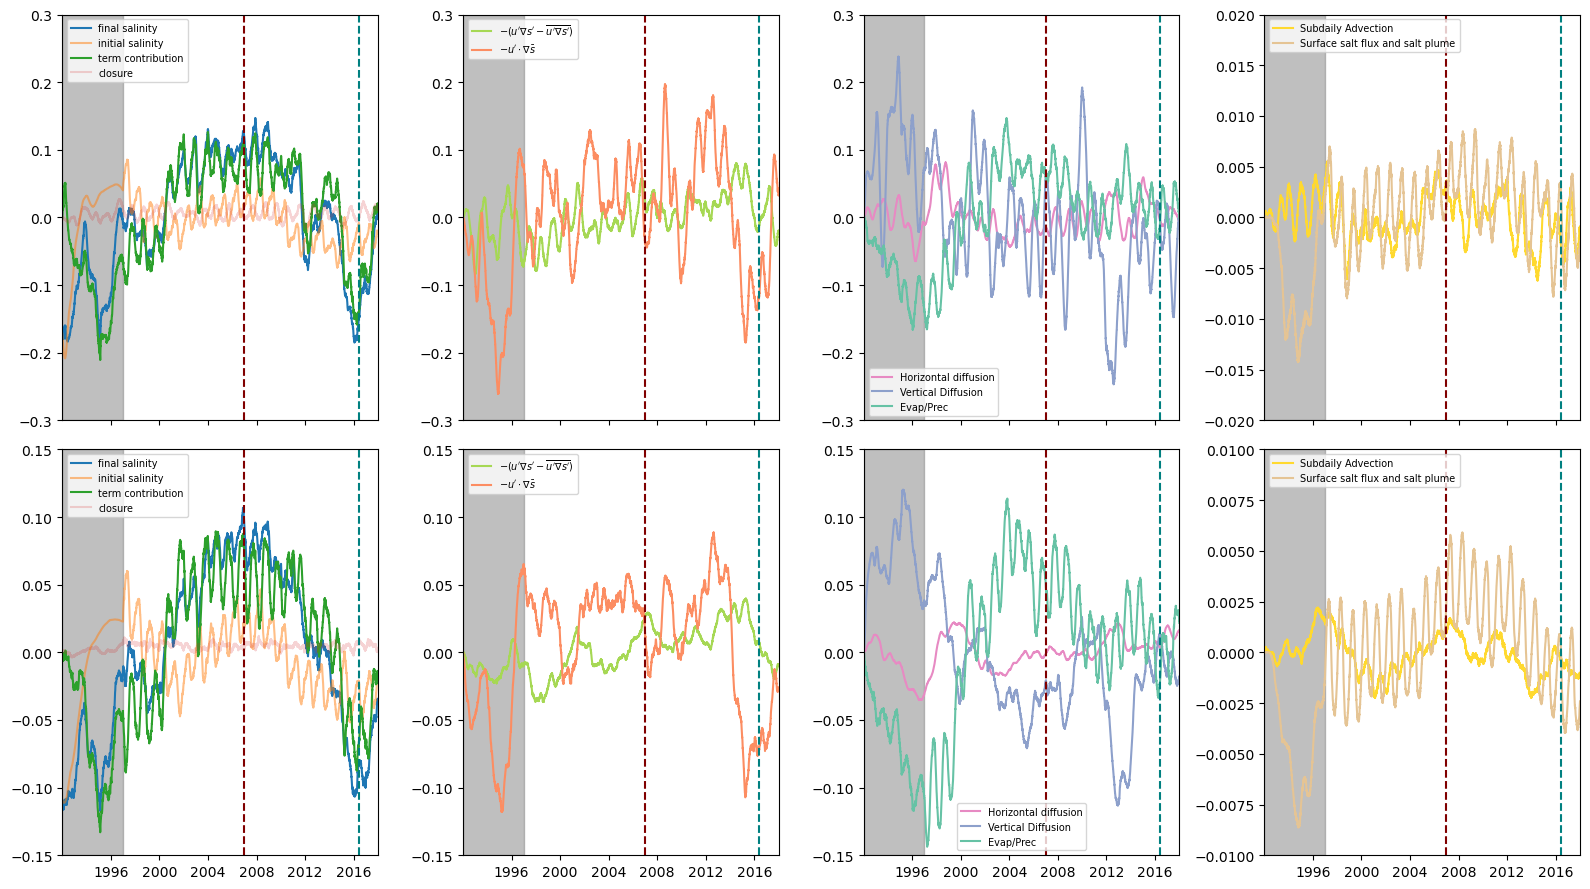

In [19]:
ttt = rtime
fig,axs = plt.subplots(2,4, figsize = (16,9),sharex = True)
fontsize = 7
axs = axs.ravel()
ylim = 0.3
small_ylim = 0.02

axs[0].plot(t,slast4,label = 'final salinity')
axs[0].plot(t,sfirst4, label = 'initial salinity',alpha = 0.5)
axs[0].plot(t,-sums4[1:]/NUMBER_OF_PARTICLE_domain4, label = 'term contribution')
axs[0].plot(t,slast4-sfirst4+sums4[1:]/NUMBER_OF_PARTICLE_domain4,label = 'closure',alpha = 0.2)
axs[0].legend(fontsize = fontsize)
axs[0].fill_betweenx([-ylim,ylim],t[0],t[1825],color = 'grey',alpha = 0.5)
axs[0].set_ylim([-ylim,ylim])
axs[0].set_xlim([t[0],t[-1]])
axs[0].plot([salty_date,salty_date],[-ylim,ylim],'--', color = salty_theme_color)
axs[0].plot([fresh_date,fresh_date],[-ylim,ylim],'--', color = fresh_theme_color)

for i,group in enumerate([['E','A'],['dif_h','dif_v','F'],['e_ua','I']]):
    for var in group:
        axs[i+1].plot(ttt, -terms4[var]/NUMBER_OF_PARTICLE_domain4,label = term_dic[var],color = color_dic[var])
    axs[i+1].legend(fontsize = fontsize)
    if i!=2:
        axs[i+1].fill_betweenx([-ylim,ylim],t[0],t[1825],color = 'grey',alpha = 0.5)
        axs[i+1].set_ylim([-ylim,ylim])
        axs[i+1].plot([salty_date,salty_date],[-ylim,ylim],'--', color = salty_theme_color)
        axs[i+1].plot([fresh_date,fresh_date],[-ylim,ylim],'--', color = fresh_theme_color)
    else:
        axs[i+1].fill_betweenx([-small_ylim,small_ylim],t[0],t[1825],color = 'grey',alpha = 0.5)
        axs[i+1].set_ylim([-small_ylim,small_ylim])
        axs[i+1].plot([salty_date,salty_date],[-small_ylim,small_ylim],'--', color = salty_theme_color)
        axs[i+1].plot([fresh_date,fresh_date],[-small_ylim,small_ylim],'--', color = fresh_theme_color)

ylim = 0.15
small_ylim = 0.01

axs[4].plot(t,slasta,label = 'final salinity')
axs[4].plot(t,sfirsta, label = 'initial salinity',alpha = 0.5)
axs[4].plot(t,-sumsa[1:]/NUMBER_OF_PARTICLE_domain_all, label = 'term contribution')
axs[4].plot(t,slasta-sfirsta+sumsa[1:]/NUMBER_OF_PARTICLE_domain_all,label = 'closure',alpha = 0.2)
axs[4].legend(fontsize = fontsize)
axs[4].fill_betweenx([-ylim,ylim],t[0],t[1825],color = 'grey',alpha = 0.5)
axs[4].set_ylim([-ylim,ylim])
axs[4].set_xlim([t[0],t[-1]])
axs[4].plot([salty_date,salty_date],[-ylim,ylim],'--', color = salty_theme_color)
axs[4].plot([fresh_date,fresh_date],[-ylim,ylim],'--', color = fresh_theme_color)

for i,group in enumerate([['E','A'],['dif_h','dif_v','F'],['e_ua','I']]):
    i+=4
    for var in group:
        axs[i+1].plot(ttt, -termsa[var]/NUMBER_OF_PARTICLE_domain_all,label = term_dic[var],color = color_dic[var])
    axs[i+1].legend(fontsize = fontsize)
    if i!=6:
        axs[i+1].fill_betweenx([-ylim,ylim],t[0],t[1825],**fill_betweenx_kwarg)
        axs[i+1].set_ylim([-ylim,ylim])
        axs[i+1].plot([salty_date,salty_date],[-ylim,ylim],'--', color = salty_theme_color)
        axs[i+1].plot([fresh_date,fresh_date],[-ylim,ylim],'--', color = fresh_theme_color)
    else:
        axs[i+1].fill_betweenx([-small_ylim,small_ylim],t[0],t[1825],**fill_betweenx_kwarg)
        axs[i+1].set_ylim([-small_ylim,small_ylim])
        axs[i+1].plot([salty_date,salty_date],[-small_ylim,small_ylim],'--', color = salty_theme_color)
        axs[i+1].plot([fresh_date,fresh_date],[-small_ylim,small_ylim],'--', color = fresh_theme_color)

plt.tight_layout()
plt.savefig('figure9.png',dpi = dpi)

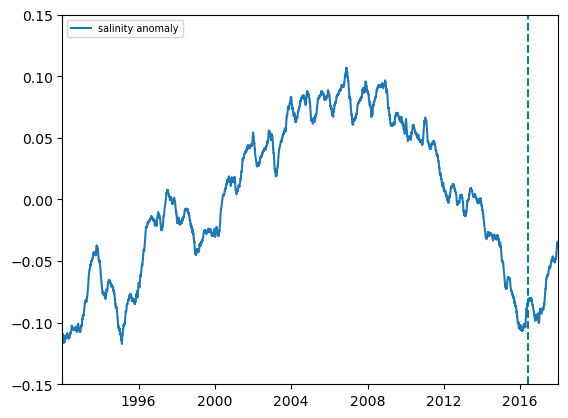

In [25]:
if regen_talk:
    plt.plot(t,slasta,label = 'salinity anomaly')
    # plt.plot(t,sfirsta, label = 'initial salinity',alpha = 0.5)
    # plt.plot(t,-sumsa[1:]/NUMBER_OF_PARTICLE_domain_all, label = 'term contribution')
    # plt.plot(t,slasta-sfirsta+sumsa[1:]/NUMBER_OF_PARTICLE_domain_all,label = 'closure',alpha = 0.2)
    plt.legend(fontsize = fontsize)
    # plt.fill_betweenx([-ylim,ylim],t[0],t[1825],color = 'grey',alpha = 0.5)
    plt.ylim([-ylim,ylim])
    plt.xlim([t[0],t[-1]])
    # plt.plot([salty_date,salty_date],[-ylim,ylim],'--', color = salty_theme_color)
    plt.plot([fresh_date,fresh_date],[-ylim,ylim],'--', color = fresh_theme_color)
    plt.savefig('talkfig0_0.png',dpi = dpi)
    plt.show()

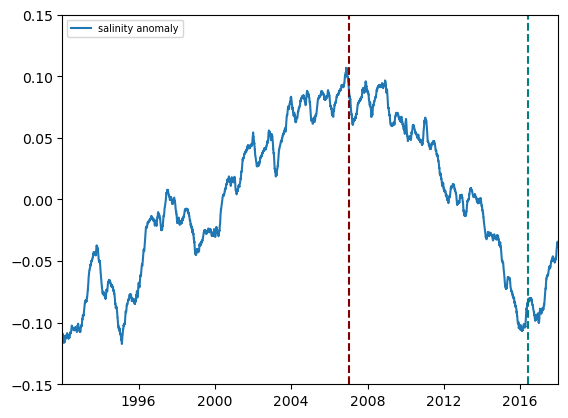

In [24]:
if regen_talk:
    plt.plot(t,slasta,label = 'salinity anomaly')
    # plt.plot(t,sfirsta, label = 'initial salinity',alpha = 0.5)
    # plt.plot(t,-sumsa[1:]/NUMBER_OF_PARTICLE_domain_all, label = 'term contribution')
    # plt.plot(t,slasta-sfirsta+sumsa[1:]/NUMBER_OF_PARTICLE_domain_all,label = 'closure',alpha = 0.2)
    plt.legend(fontsize = fontsize)
    # plt.fill_betweenx([-ylim,ylim],t[0],t[1825],color = 'grey',alpha = 0.5)
    plt.ylim([-ylim,ylim])
    plt.xlim([t[0],t[-1]])
    plt.plot([salty_date,salty_date],[-ylim,ylim],'--', color = salty_theme_color)
    plt.plot([fresh_date,fresh_date],[-ylim,ylim],'--', color = fresh_theme_color)
    plt.savefig('talkfig0_1.png',dpi = dpi)
    plt.show()